# Econ 212: Problem Set 3

In [1]:
from fredapi import Fred
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

## Problem 1: Seignorage and inflation

### Part (b)

In [3]:
def est_param(start_date, end_date, monthly_end_date):
    
    ## get and process data
    #######################
    
    # money
    M_monthly = fred.get_series('M2SL', observation_start = start_date, observation_end = monthly_end_date)
    M = np.mean(np.reshape(M_monthly, (3, len(M_monthly) // 3), order = 'F'), axis = 0)

    # prices
    P = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

    # interest rates
    i_monthly = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = monthly_end_date)
    i = np.mean(np.reshape(i_monthly, (3, len(i_monthly) // 3), order = 'F'), axis = 0)

    # consumption
    C = fred.get_series('PCEC', observation_start = start_date, observation_end = end_date)
    
    # real money balances
    m = M / P

    # real consumption
    c = C / P
    
    ## fit linear regression to estimate preferences parameters
    ###########################################################
    
    x = np.array([np.log(c), np.log((1 / i) + 1)]).T
    y = np.array(np.log(m))

    model = LinearRegression().fit(x, y)

    print('intercept:', round(model.intercept_, 4), 
          '\ncoefficients:', [round(coef, 4) for coef in model.coef_])
    
    gamma = 1 / model.coef_[1]
    phi = np.exp(gamma * model.intercept_)
    sigma = gamma * model.coef_[0]

    print('gamma:', round(gamma, 4), 
          '\nphi:', round(phi, 4), 
          '\nsigma:', round(sigma, 4))
    
    return M_monthly, M, P, i_monthly, i, C, m, c

In [4]:
M_monthly, M, P, i_monthly, i, C, m, c = est_param('1959-01-01', '2022-10-01', '2022-12-01')

intercept: 0.3001 
coefficients: [0.8829, 0.114]
gamma: 8.7712 
phi: 13.9037 
sigma: 7.744


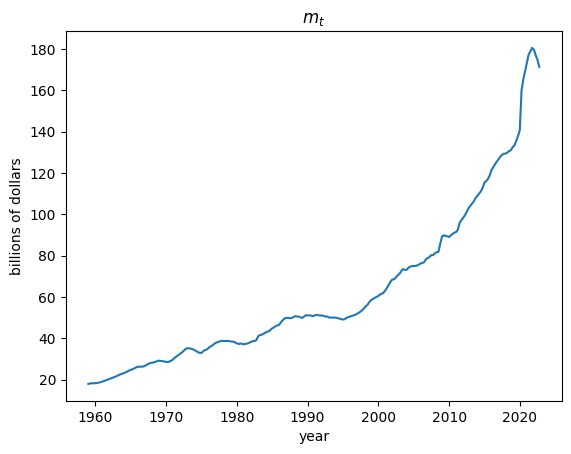

In [5]:
dates = pd.DataFrame(m).index

plt.plot(dates, m)
plt.title('$m_t$')
plt.xlabel('year')
plt.ylabel('billions of dollars')
plt.show()

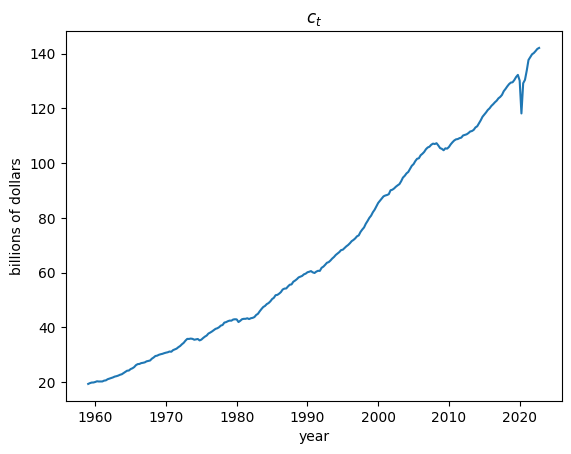

In [6]:
plt.plot(dates, c)
plt.title('$c_t$')
plt.xlabel('year')
plt.ylabel('billions of dollars')
plt.show()

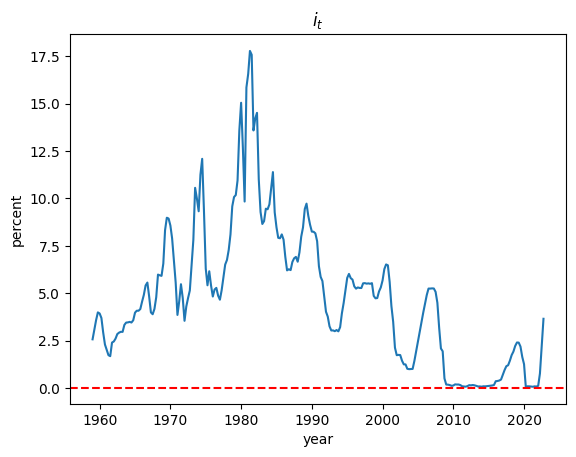

In [7]:
plt.plot(dates, i)
plt.title('$i_t$')
plt.xlabel('year')
plt.ylabel('percent')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

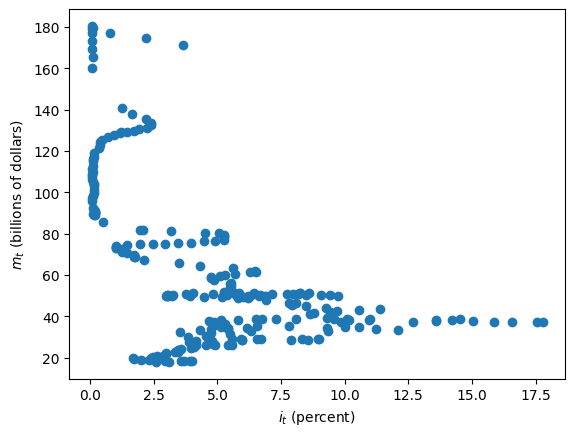

In [8]:
plt.scatter(i, m)
plt.xlabel(r'$i_t$ (percent)')
plt.ylabel(r'$m_t$ (billions of dollars)')
plt.show()

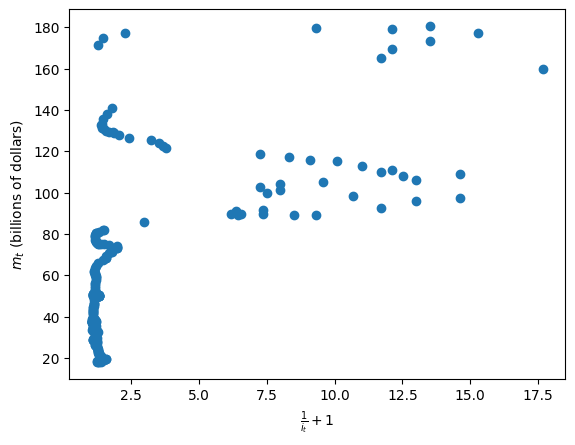

In [9]:
plt.scatter(1 / i + 1, m)
plt.xlabel('$\\frac{1}{i_t}+1$')
plt.ylabel(r'$m_t$ (billions of dollars)')
plt.show()

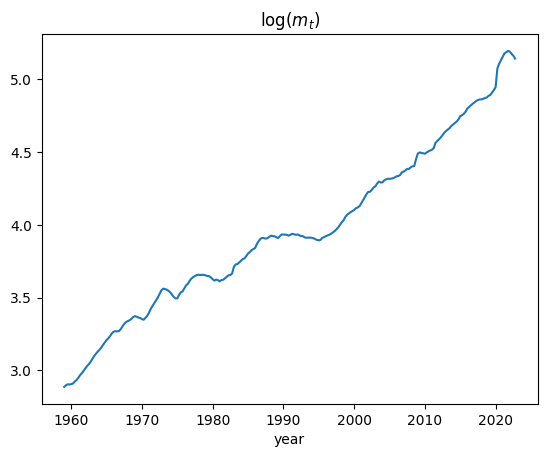

In [10]:
plt.plot(dates, np.log(m))
plt.title('$\\log(m_t)$')
plt.xlabel('year')
plt.show()

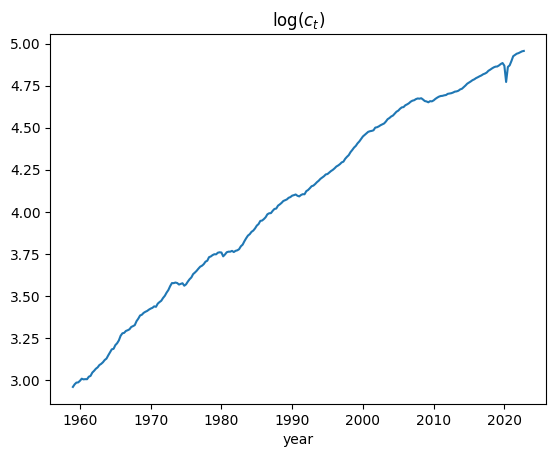

In [11]:
plt.plot(dates, np.log(c))
plt.title('$\\log(c_t)$')
plt.xlabel('year')
plt.show()

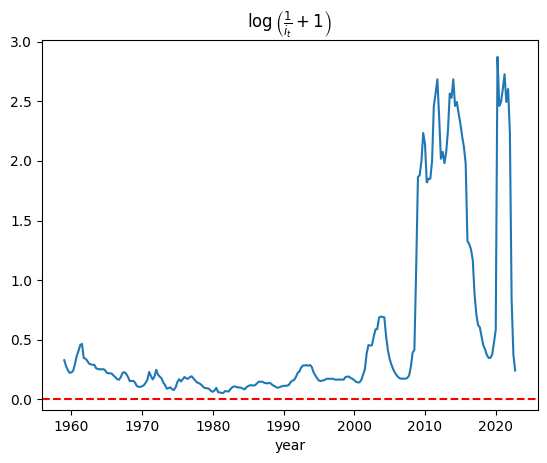

In [12]:
plt.plot(dates, np.log(1 / i + 1))
plt.title('$\\log\\left(\\frac{1}{i_t}+1\\right)$')
plt.xlabel('year')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

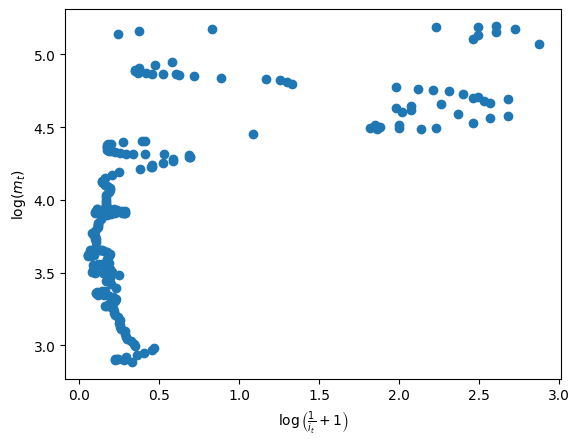

In [13]:
plt.scatter(np.log(1 / i + 1), np.log(m))
plt.xlabel('$\\log\\left(\\frac{1}{i_t}+1\\right)$')
plt.ylabel('$\\log(m_t)$')
plt.show()

In [14]:
est_param('1960-01-01', '1969-10-01', '1969-12-01');

intercept: -0.5723 
coefficients: [1.1595, 0.145]
gamma: 6.8985 
phi: 0.0193 
sigma: 7.9988


In [15]:
est_param('1970-01-01', '1979-10-01', '1979-12-01');

intercept: 0.1707 
coefficients: [0.9269, 0.2606]
gamma: 3.8379 
phi: 1.9256 
sigma: 3.5575


In [16]:
est_param('1980-01-01', '1989-10-01', '1989-12-01');

intercept: 0.4507 
coefficients: [0.8284, 0.9471]
gamma: 1.0558 
phi: 1.6093 
sigma: 0.8746


In [17]:
est_param('1990-01-01', '1999-10-01', '1999-12-01');

intercept: 2.2286 
coefficients: [0.4128, -0.1223]
gamma: -8.1786 
phi: 0.0 
sigma: -3.3761


In [18]:
est_param('2000-01-01', '2009-10-01', '2009-12-01');

intercept: -1.003 
coefficients: [1.15, 0.0757]
gamma: 13.2093 
phi: 0.0 
sigma: 15.1908


In [19]:
est_param('2010-01-01', '2019-10-01', '2019-12-01');

intercept: -6.5928 
coefficients: [2.3599, 0.04]
gamma: 24.9868 
phi: 0.0 
sigma: 58.9663


### Part (c)

In [20]:
# convert M and P to annual frequency
M_annual = np.mean(np.reshape(M, (4, len(M) // 4), order = 'F'), axis = 0)
P_annual = np.mean(np.reshape(P, (4, len(P) // 4), order = 'F'), axis = 0)

# calculate seignorage
s = np.diff(M_annual) / P_annual[1:]

# calculate change in real money balances
m_annual = np.mean(np.reshape(m, (4, len(m) // 4), order = 'F'), axis = 0)
s1 = np.diff(m_annual)

# calculate 'inflation tax' term
s2 = s - s1

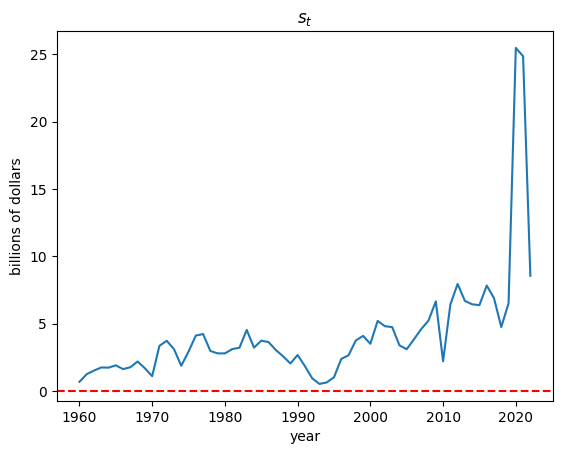

In [21]:
# date range is now from 1960 to 2022
plt.plot(range(1960, 2023), s)
plt.title('$s_t$')
plt.xlabel('year')
plt.ylabel('billions of dollars')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

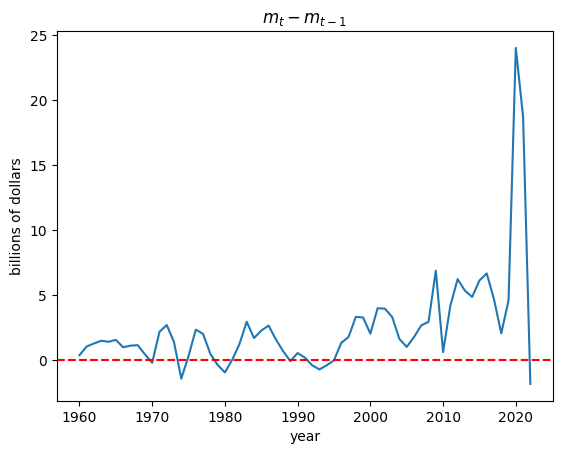

In [22]:
plt.plot(range(1960, 2023), s1)
plt.title('$m_t-m_{t-1}$')
plt.xlabel('year')
plt.ylabel('billions of dollars')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

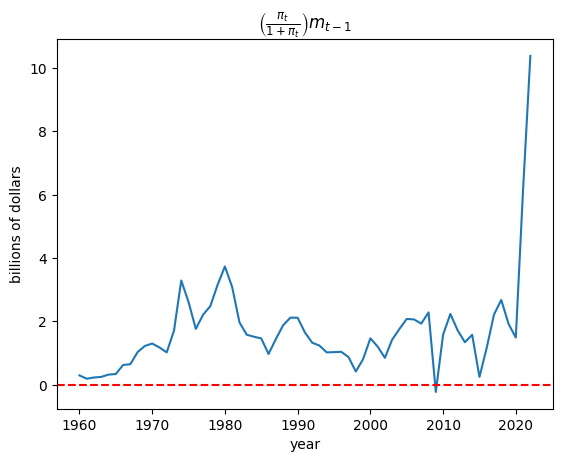

In [23]:
plt.plot(range(1960, 2023), s2)
plt.title('$\\left(\\frac{\\pi_t}{1+\\pi_t}\\right)m_{t-1}$')
plt.xlabel('year')
plt.ylabel('billions of dollars')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

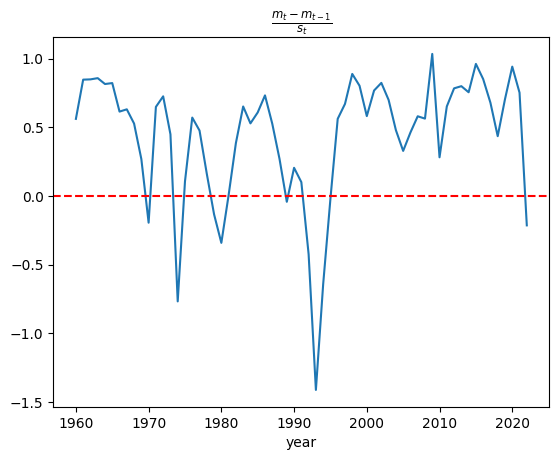

In [24]:
# see what percentage of seignorage has been the change in real money balances
plt.plot(range(1960, 2023), s1 / s)
plt.title('$\\frac{m_t-m_{t-1}}{s_t}$')
plt.xlabel('year')
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

## Problem 2: SVAR impulse response to monetary shocks

### Part A

In [25]:
real_GDP = fred.get_series('GDPC1', observation_start = '1959-01-01', observation_end = '2007-10-01')
price_deflator = fred.get_series('GDPDEF', observation_start = '1959-01-01', observation_end = '2007-10-01')
fed_funds_rate = fred.get_series('FEDFUNDS', observation_start = '1959-01-01', observation_end = '2007-12-01')

In [26]:
growth_rate = [400 * np.log(real_GDP[t] / real_GDP[t-1]) for t in range(1,len(real_GDP))]
inflation_rate = [400 * np.log(price_deflator[t] / price_deflator[t-1]) for t in range(1,len(price_deflator))]
fed_funds_rate = np.mean(np.reshape(fed_funds_rate, (3, len(fed_funds_rate) // 3), order = 'F'), axis = 0)[1:]

### Part B

In [27]:
def run_var(X, var_list, robust = False):
    # convert
    Xt_df = pd.DataFrame(X, columns = var_list)

    # Create lags 1 - 4
    lagged_Xt = pd.concat((Xt_df.shift(1), Xt_df.shift(2), Xt_df.shift(3), Xt_df.shift(4)), axis = 1)
    
    # Rename columns
    # For each lagged period
    for i in range(4):
        # For each variable
        for j in range(len(var_list)):
            lagged_Xt.columns.values[j + 3 * i] = var_list[j] + f'{i}'

    # Drop the first four rows
    lagged_Xt = lagged_Xt.iloc[4:]

    # Run regression on lagged values
    B_gamma_inv = np.linalg.inv(lagged_Xt.T @ lagged_Xt) @ (lagged_Xt.T @ Xt_df[4:])
    B_gamma_inv = np.matrix(B_gamma_inv)

    # Get coefficients for each lag
    B_gamma_inv_1 = B_gamma_inv[0:len(var_list), :]
    B_gamma_inv_2 = B_gamma_inv[len(var_list):2 * len(var_list), :]
    B_gamma_inv_3 = B_gamma_inv[2 * len(var_list):3 * len(var_list), :]
    B_gamma_inv_4 = B_gamma_inv[3 * len(var_list):4 * len(var_list), :]

    # Calculate residuals
    residuals = np.matrix(Xt_df[4:]) - lagged_Xt @ B_gamma_inv
    
    if robust:
        return B_gamma_inv_1, B_gamma_inv_2, B_gamma_inv_3, B_gamma_inv_4, residuals, B_gamma_inv, lagged_Xt
    
    return B_gamma_inv_1, B_gamma_inv_2, B_gamma_inv_3, B_gamma_inv_4, residuals

def compute_irf(B_gamma_inv_1, B_gamma_inv_2, B_gamma_inv_3, B_gamma_inv_4, residuals, periods, shock):
    # Get L
    L = np.linalg.cholesky(np.cov(residuals.T))

    # Seed the IRF with initial periods
    irf = np.zeros((periods, len(var_list)))
    irf[0] = np.dot(L, shock)
    irf[1] = B_gamma_inv_1.T @ irf[0]
    irf[2] = B_gamma_inv_1.T @ irf[1] + B_gamma_inv_2.T @ irf[0]
    irf[3] = B_gamma_inv_1.T @ irf[2] + B_gamma_inv_2.T @ irf[1] + B_gamma_inv_3.T @ irf[0]

    # Iterate forward through time
    for t in range(4, periods):
        irf[t] = B_gamma_inv_1.T @ irf[t-1] + B_gamma_inv_2.T @ irf[t-2] + B_gamma_inv_3.T @ irf[t-3] + B_gamma_inv_4.T @ irf[t-4]

    return irf    

In [28]:
def bootstrap_irf(X, periods, var_list, K, shock):
    # run the var
    B_gamma_inv_1, B_gamma_inv_2, B_gamma_inv_3, B_gamma_inv_4, residuals,B_gamma_inv, X_lagged  = run_var(X, var_list, robust = True)
    
    # get irf
    irf = compute_irf(B_gamma_inv_1, B_gamma_inv_2, B_gamma_inv_3, B_gamma_inv_4, residuals, periods, shock)

    # make some useful constants
    covs = np.shape(residuals)[1]
    n = np.shape(residuals)[0]
    X_boot = np.zeros((n, covs))

    # make 3 dimensional matrix to store irfs
    response_array = np.zeros((periods, covs, K))
        
    for k in range(K):
        eps_boot = np.zeros((n, covs))

        for i in range(covs):
            eps_boot[:,i] = np.random.choice(residuals.iloc[:,i], size = n, replace = True)
                    
        X_boot = X_lagged @ B_gamma_inv + eps_boot
        
        X_boot.columns = var_list
            
        # do the VAR and get irf        
        # Run regression on lagged values
        B = np.linalg.inv(X_lagged.T @ X_lagged) @ (X_lagged.T @ X_boot)
        B = np.matrix(B)

        # Get coefficients for each lag
        B1 = B[0:len(var_list), :]
        B2 = B[len(var_list):2 * len(var_list), :]
        B3 = B[2 * len(var_list):3 * len(var_list), :]
        B4 = B[3 * len(var_list):4 * len(var_list), :]

        # Calculate residuals
        eps_boot = np.matrix(X_boot) - X_lagged @ B
        
        # compute IRF
        response_array[:,:, k] = compute_irf(B1, B2, B3, B4, eps_boot, periods, shock)
        
        
    # plot
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    
    for i in range(np.shape(X)[1]):        
        # get the 5th and 95th percentile outcomes        
        irf_upper_ci = [np.percentile(response_array[t, i, :], 97.5) for t in range(periods)]
        irf_lower_ci = [np.percentile(response_array[t, i, :], 2.5) for t in range(periods)]
            
        var = var_list[i]

        ax = plt.subplot(np.shape(X)[1], 1, i + 1)

        ax.plot(irf[:, i]/irf[0,-1], linewidth=2.5)
        ax.plot(irf_upper_ci/irf[0,-1], linewidth = 2.5, color = "b", linestyle = ":")
        ax.plot(irf_lower_ci/irf[0,-1], linewidth = 2.5, color = "b", linestyle = ":")
        ax.set_title(f'{var} response to 100 bp monetary innovation')
        ax.set_ylabel('deviation from steady state')
        ax.set_xlabel('quarters')
        ax.axhline(0, color = "r", linestyle = "--")
    plt.show()

### i

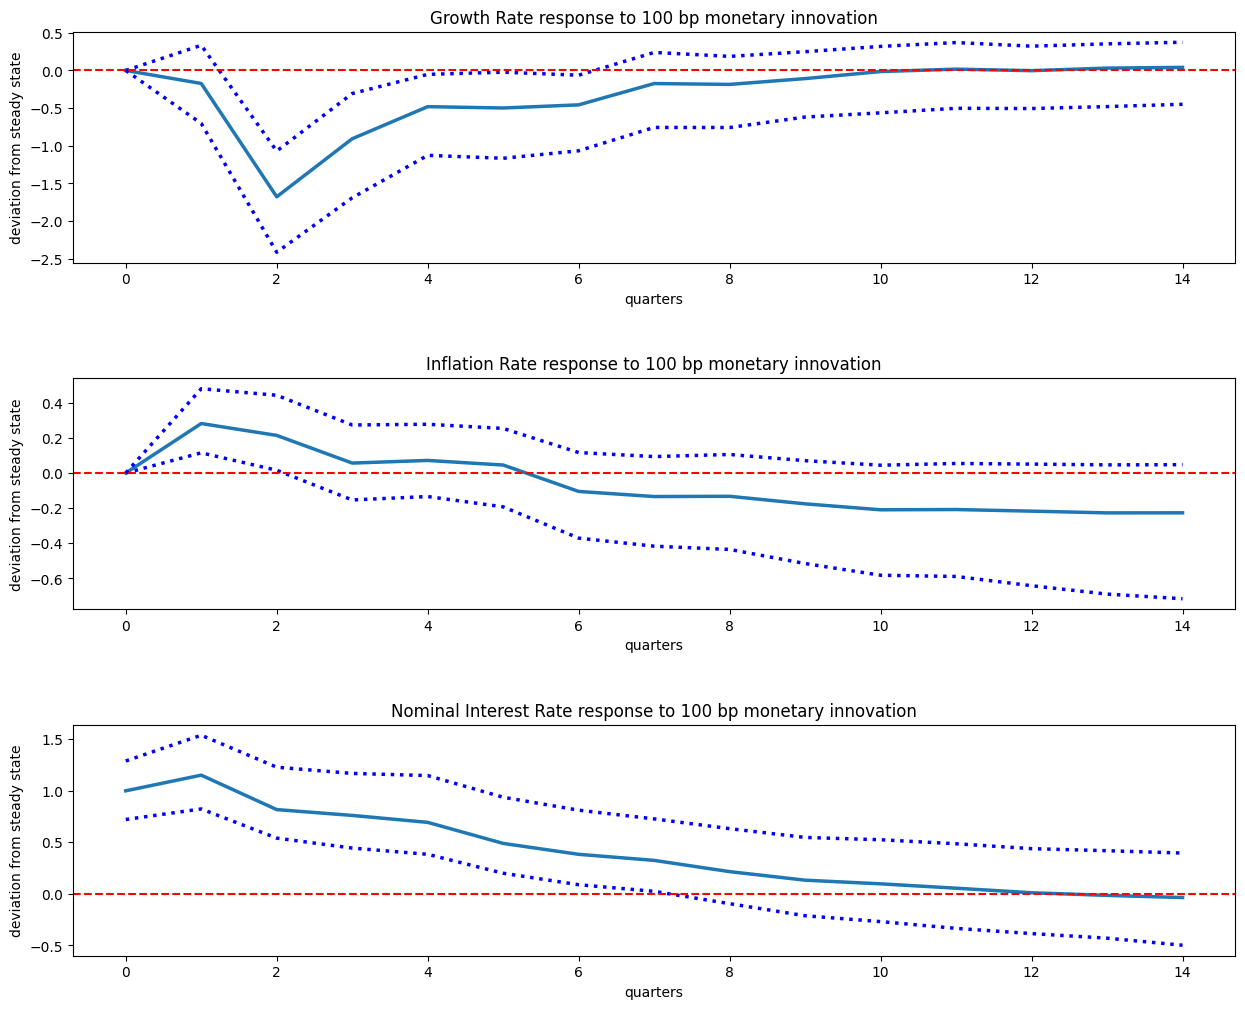

In [29]:
X = [(growth_rate[t], inflation_rate[t], fed_funds_rate[t]) for t in range(len(inflation_rate))]
shock = [0, 0, 1]
var_list = ['Growth Rate','Inflation Rate', 'Nominal Interest Rate']

bootstrap_irf(X, 15, var_list, 500, shock)

### ii

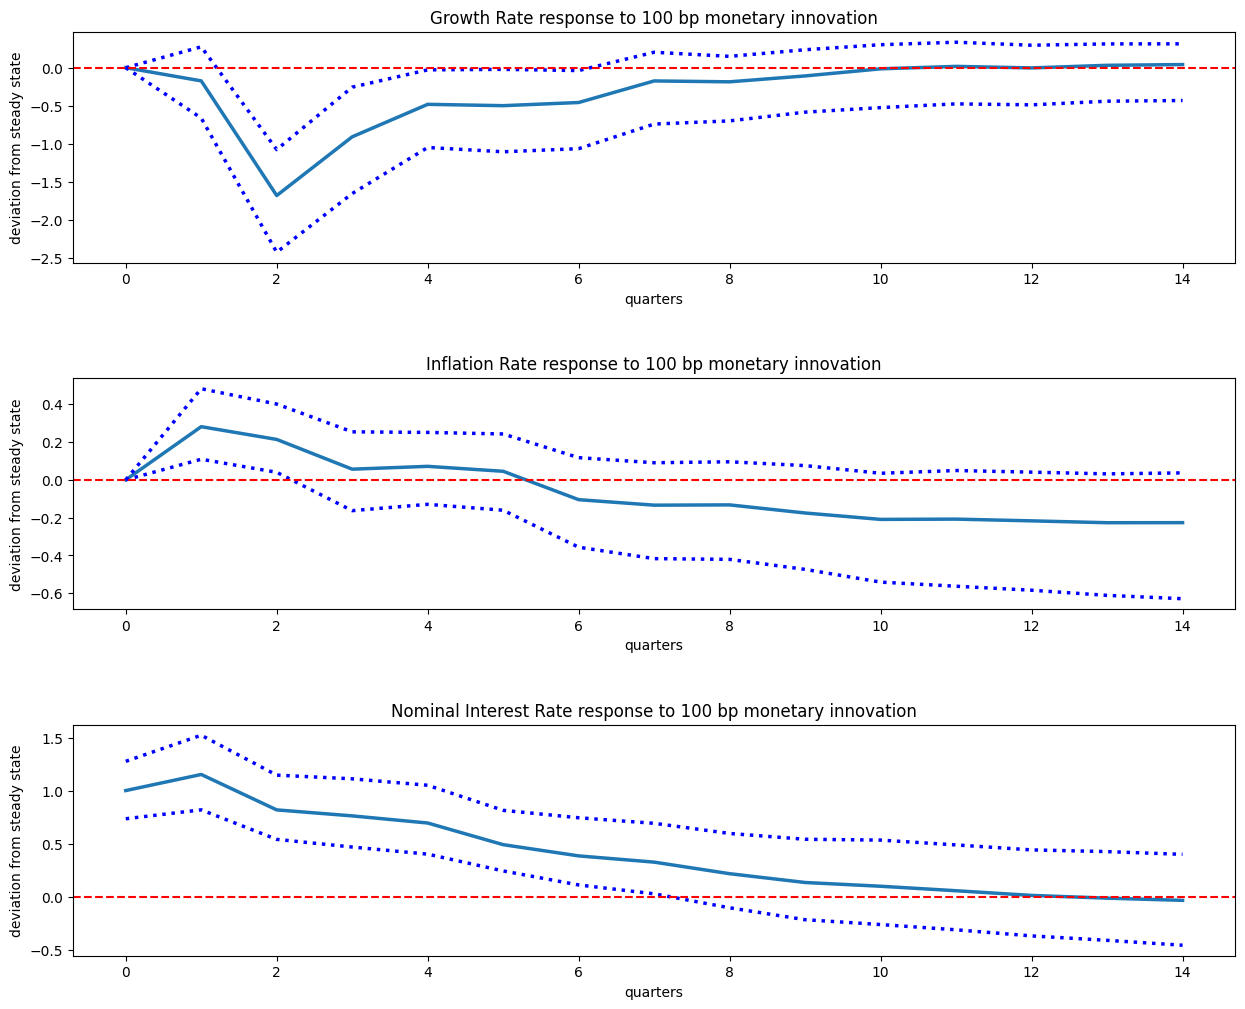

In [30]:
X_permuted = [(inflation_rate[t], growth_rate[t], fed_funds_rate[t]) for t in range(len(inflation_rate))]
var_list_permuted = ['Inflation Rate','Growth Rate', 'Nominal Interest Rate']

bootstrap_irf(X, 15, var_list, 500, shock)

### iii

In [31]:
total_reserves = np.log(fred.get_series('TOTRESNS', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])
m2 = np.log(fred.get_series('M2SL', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])

In [32]:
X_additional = [(growth_rate[t], inflation_rate[t], total_reserves[t], m2[t] ,fed_funds_rate[t]) 
                for t in range(len(fed_funds_rate))]

shock = [0,0,0,0,1]
var_list = ['Growth Rate','Inflation Rate','Log total reserves', 'Log M2', 'Nominal Interest Rate']

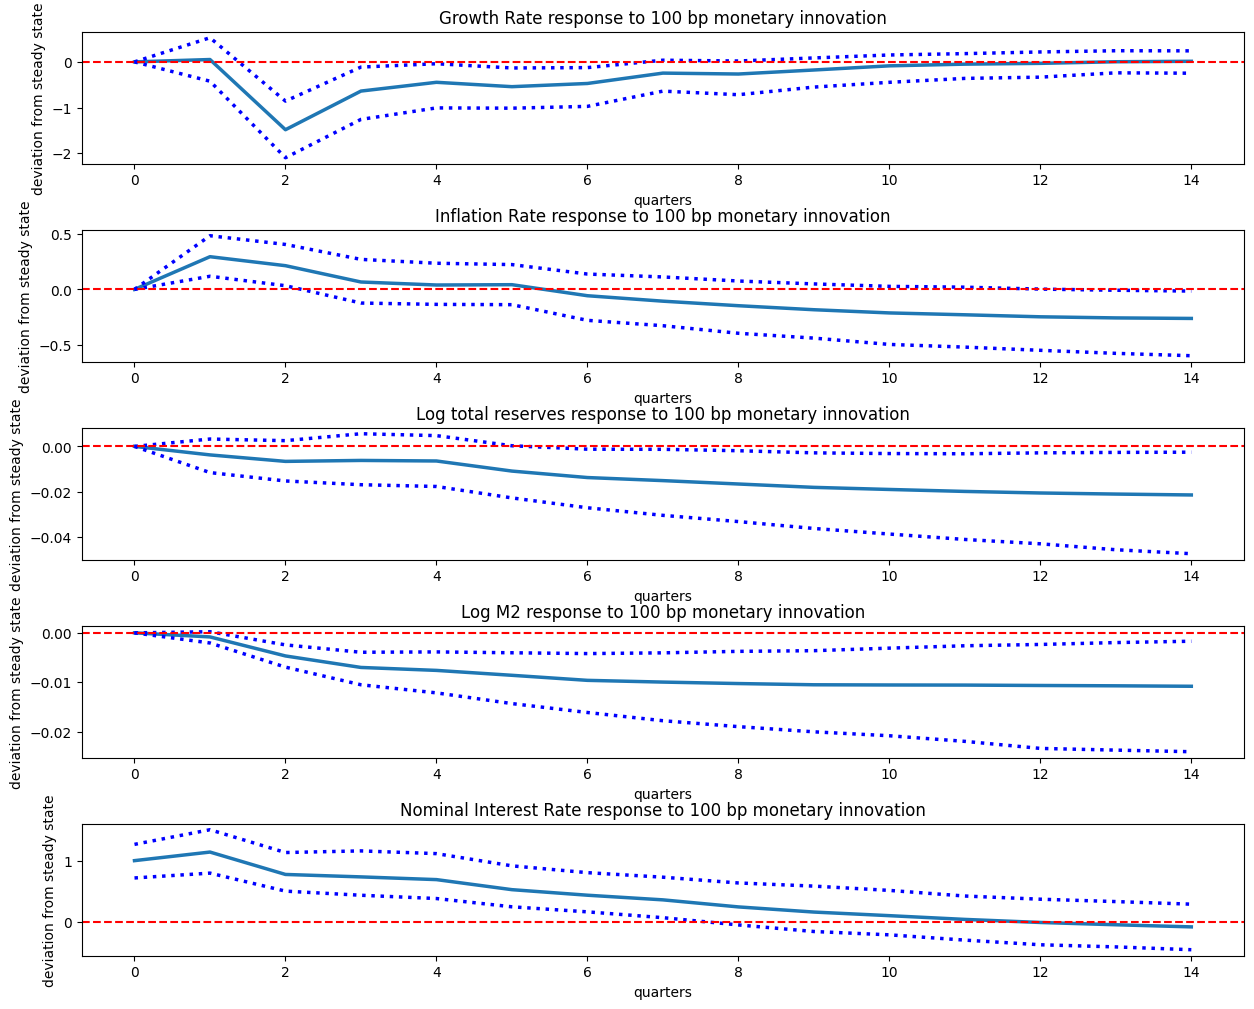

In [33]:
bootstrap_irf(X_additional, 15, var_list, 500, shock)